In [8]:
#import tensorflow as tf
#import tensorflow.keras as K
from tensorflow.keras.applications.xception import Xception

import keras
#from tensorflow.keras import layers, models
#from keras.preprocessing.image import ImageDataGenerator
#import numpy as np

import time
from datetime import timedelta

#import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
#from tensorflow.data import Dataset

from tensorflow.keras.callbacks import EarlyStopping
#from tqdm import tqdm

from util_functions import *

In [2]:
DATA_PATH = "../../Data/"
IMG_SIZE = (299, 299)
IMAGES_PATH_SEPARATED = DATA_PATH+"HAM10000_images_separated_xception_balanced/"
IMAGES_PATH_VALIDATION = DATA_PATH+"HAM10000_images_separated_validation_xception/"

In [3]:
batch_size = 32
generator = ImageDataGenerator(validation_split=0.2)
train_data = generator.flow_from_directory( 
        subset="training",
        directory=IMAGES_PATH_SEPARATED,
        target_size=IMG_SIZE,
        batch_size=batch_size
)
test_data = generator.flow_from_directory( 
        subset="validation",
        directory=IMAGES_PATH_SEPARATED,
        target_size=IMG_SIZE,
        batch_size=batch_size
)

Found 781 images belonging to 7 classes.
Found 192 images belonging to 7 classes.


## Xception

In [4]:
# Loading VGG16 model without top layers to substitute with custom Dense layers
base_model = Xception(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False # Not trainable weights
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [40]:
# Enable training for convolutional layers in last (14th) block
if False:
    for layer in base_model.layers:
        # These 2 layers will enable 4,741,632 Trainable params: 
        if layer.name not in ["block14_sepconv1", "block14_sepconv2"]:
            layer.trainable = False

    base_model.summary()

# Disable training for BatchNormalization Layers
if False:
    for layer in base_model.layers:
        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = False
        else:
            layer.trainable = True

    base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 229, 229, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 114, 114, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 114, 114, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

### TODO : https://stackoverflow.com/questions/54011173/is-there-any-documentation-about-default-weight-initializer-in-keras
Layer Weight Init

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten_3 (Flatten)         (None, 204800)            0         
                                                                 
 dense_15 (Dense)            (None, 256)               52429056  
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_16 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                      

D:\Programs\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


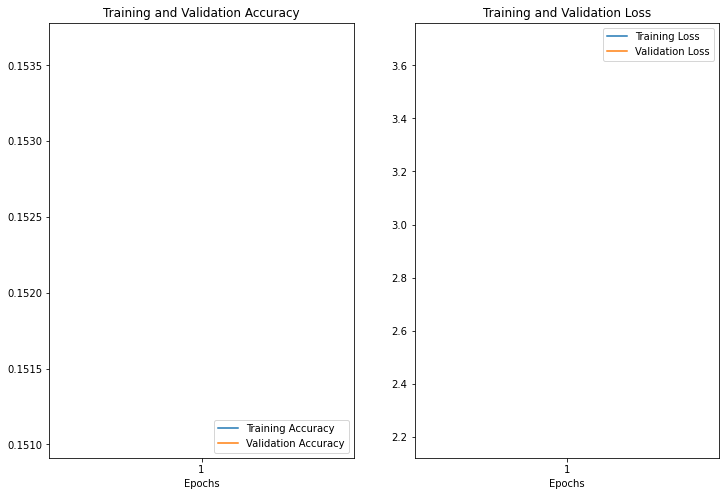

In [9]:
# Measure time
start_time = time.time()

epochs = 1
dropout_rate = 0.4
weight_init = tf.keras.initializers.HeNormal() # kernel_initializer in Dense layer

model = Sequential([
    #layers.Rescaling(1./255, input_shape=IMG_SIZE+(3,)),
    # Convert input between -1 and 1
    layers.Rescaling(1./127.5, offset=-1, input_shape=IMG_SIZE+(3,)),
    base_model,
    
    #layers.GlobalAveragePooling2D(), # Same as original Xception model
    layers.Flatten(),
    layers.Dense(256, kernel_initializer=weight_init),
    layers.Dropout(rate=dropout_rate),
    layers.BatchNormalization(),
    layers.ReLU(),
    
    layers.Dense(256, kernel_initializer=weight_init),
    layers.Dropout(rate=dropout_rate),
    layers.BatchNormalization(),
    layers.ReLU(),
    
    layers.Dense(256, kernel_initializer=weight_init),
    layers.Dropout(rate=dropout_rate),
    layers.BatchNormalization(),
    layers.ReLU(),
    
    layers.Dense(256, kernel_initializer=weight_init),
    layers.Dropout(rate=dropout_rate),
    layers.BatchNormalization(),
    layers.ReLU(),
    
    layers.Dense(7, activation="softmax")
])

model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00025, epsilon=1e-06) 
# RMSprop(learning_rate=0.00002) # Adagrad() # Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_loss', mode='min', patience=3,  
                   restore_best_weights=True, min_delta=0.01)

history = model.fit(train_data, validation_data=test_data, 
                    batch_size=batch_size, epochs=epochs) #, callbacks=[es])
epochs = len(history.history['loss'])

print("Epoch Length : {0}".format(epochs))
print("Time Elapsed : ", timedelta(seconds=(time.time() - start_time)))

# Custom Mask Warning indicates on loading model will require mask layers to be passed as custom_objects
model.save("output\keras_models\skin_classifier_Xception_{0}.keras".format(epochs))
#evaluate_model(model, train_data, test_data)
print_training_history(history)
'''''';
# Xception Xception + GlobalAveragePooling2D +D0.04 +BN 10 epochs Augmentation:Rotation

In [10]:
start_time = time.time()
evaluate_model(model, train_data, test_data)
print("Time Elapsed : ", timedelta(seconds=(time.time() - start_time)))

Model Accuracy      : 0.1690
Validation Accuracy : 0.1510
Time Elapsed :  0:01:04.095678


In [ ]:
# VGG16    (BN+DO) 10 epochs 53/58 
# VGG16 _2 (BN+D0) 10 epochs 63/64

In [ ]:
# NOT TESTED
from keras.utils.vis_utils import plot_model
plot_model(model, to_file="output/vgg16.png")